In [1]:
import torch

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model

Loading contents from file...


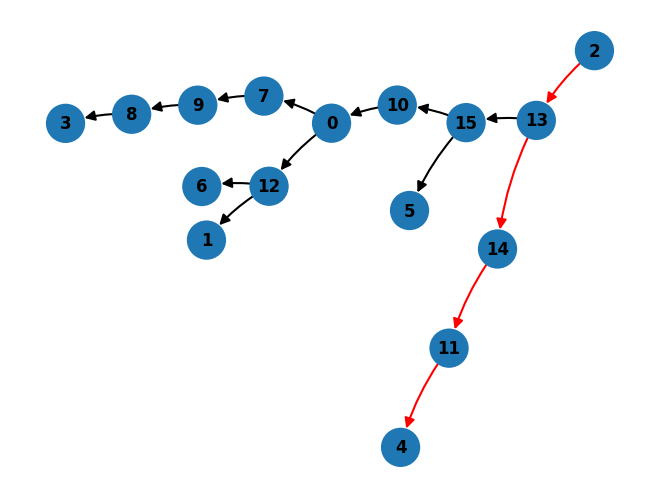

In [2]:
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

In [3]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))

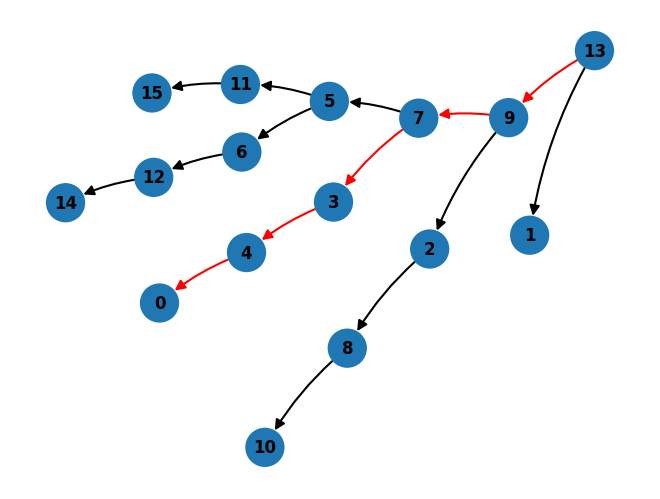

In [4]:
import random

pred = generate_example(16, 0, order="backward", path_length=5)
if is_model_correct(model, dataset, pred):
    parse_example(pred)
cache = get_example_cache(pred, model, dataset)

In [1]:
from 
display_head(cache, pred, 1, 0, show=True)

NameError: name 'display_head' is not defined

### Compare Subpaths to Full Path

In [5]:
def delete_non_paths(input_dict):
    keys_to_delete = [key for key, value in input_dict.items() if len(value) <= 2]
    for key in keys_to_delete:
        del input_dict[key]
    return input_dict

special_chars = [",", ":", "|"]
def get_paths(cache, labels, threshold=0.6):

    paths = {}
    for layer in range(1, 6):
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in range(seq_len):       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos].replace(">", "")
                    previous_token = labels[attended_pos - 1].replace(">", "")
                    if not attended_token in special_chars and not previous_token in special_chars:
                        identifier = (current_pos, current_token)
                        if identifier in paths.keys():
                            paths[identifier].append(previous_token)
                        else:
                            paths[identifier] = [attended_token, previous_token]
    
    paths = delete_non_paths(paths)
    return paths

In [6]:
def can_construct_full_path(subpaths, full_path):
    # create a set of edges from the subpaths
    edges = set()
    for subpath in subpaths:
        for i in range(len(subpath) - 1):
            edges.add((subpath[i], subpath[i+1]))

    # create a set of edges required to traverse the full path
    required_edges = set()
    for i in range(len(full_path) - 1):
        required_edges.add((full_path[i], full_path[i+1]))

    # check if all required edges are in the set of edges from the subpaths
    return required_edges.issubset(edges)

['N0_8', 'N1_>0', 'N2_,', 'N3_8', 'N4_>15', 'N5_,', 'N6_0', 'N7_>5', 'N8_,', 'N9_15', 'N10_>4', 'N11_,', 'N12_5', 'N13_>14', 'N14_,', 'N15_4', 'N16_>2', 'N17_,', 'N18_4', 'N19_>12', 'N20_,', 'N21_2', 'N22_>13', 'N23_,', 'N24_12', 'N25_>3', 'N26_,', 'N27_3', 'N28_>1', 'N29_,', 'N30_3', 'N31_>11', 'N32_,', 'N33_1', 'N34_>9', 'N35_,', 'N36_11', 'N37_>6', 'N38_,', 'N39_11', 'N40_>10', 'N41_,', 'N42_6', 'N43_>7', 'N44_|', 'N45_10', 'N46_:', 'N47_8', 'N48_>15', 'N49_>4', 'N50_>12', 'N51_>3', 'N52_>11', 'N53_>10', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
8>0,8>15,0>5,15>4,5>14,4>2,4>12,2>13,12>3,3>1,3>11,1>9,11>6,11>10,6>7|10:8>15>4>12>3>11>10
['0_ 15', '1_ 4', '2_ 12', '3_ 3', '4_ 11', '5_ 10']
{(13, '>14'): ['5', '0', '8'], (16, '>2'): ['4', '15', '8'], (19, '>12'): ['4', '15', '8'], (22, '>13'): ['2', '4', '15'], (25, '>3'): ['12', '4', '15'], (28, '>1'): ['3', '12', '4'], (31, '>11'): ['3', '12', '4'], (34, '>9'): ['1', '3

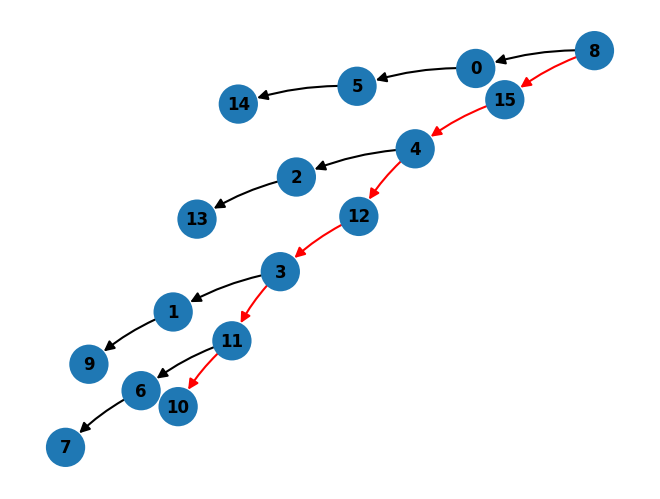

In [7]:
import random
n_examples = 1
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="forward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    print(graph_numbered)
    print(graph)
    print(full_pat_numbered)
    print(subpaths)
    parse_example(graph)


In [ ]:
#plotting examples where filtered_position is not there.
filtered_position=36
node_filter=">6"
n_examples = 100
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="forward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    node_position=-1
    for i, component in enumerate(graph_split):
        if dataset.idx2tokens[component] == node_filter:
           node_position = i
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    keys=[]
    for path in subpaths:
        (key,key_value)=path
        keys.append(key)
    if filtered_position not in keys:
        print(f'node_position {node_position}')
        print(graph_numbered)
        print(graph)
        print(full_pat_numbered)
        print(subpaths)
        parse_example(graph)

In [8]:
import random
n_examples = 300
subpaths_all_forward =[]
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="forward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    #print(graph_numbered)
    #print((subpaths))
    
    subpaths_all_forward.append(subpaths)


In [55]:
import random
n_examples = 300
subpaths_all_backward =[]
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="backward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    #print(graph_numbered)
    #print((subpaths))
    
    subpaths_all_backward.append(subpaths)

In [56]:
import random
n_examples = 300
subpaths_all_random =[]
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="random")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    #print(graph_numbered)
    #print((subpaths))
    
    subpaths_all_random.append(subpaths)


In [49]:
from collections import Counter
results={}
for subpath in subpaths_all_random:
    for key, value in subpath.items():
        if key[0] in results:
            results[key[0]].append(value[0])
        elif key[0]<47:
            results[key[0]]=[]
            results[key[0]].append(value[0])

for key, value in results.items():
    occurrences = Counter(value)
    total_count = len(value)
    percentages= []
    for key_occ, value_occ in occurrences.items():
        percentage = (value_occ / total_count) * 100
        percentages.append(f"{key_occ}: {percentage:.2f}%")

    print(f'{key}: total{total_count} {percentages}')

22: total50 ['11: 4.00%', '8: 8.00%', '7: 8.00%', '5: 8.00%', '15: 4.00%', '14: 4.00%', '0: 2.00%', '6: 8.00%', '10: 4.00%', '3: 8.00%', '9: 8.00%', '1: 6.00%', '2: 12.00%', '4: 8.00%', '12: 4.00%', '13: 4.00%']
34: total138 ['6: 5.80%', '9: 5.80%', '0: 3.62%', '11: 5.80%', '10: 7.25%', '2: 9.42%', '1: 6.52%', '7: 10.14%', '8: 8.70%', '5: 4.35%', '3: 7.97%', '15: 7.25%', '14: 2.90%', '4: 6.52%', '12: 5.07%', '13: 2.90%']
36: total125 ['6: 76.00%', '5: 4.80%', '7: 0.80%', '12: 8.80%', '14: 2.40%', '9: 0.80%', '15: 0.80%', '10: 0.80%', '3: 1.60%', '4: 0.80%', '1: 0.80%', '0: 1.60%']
38: total194 ['10: 100.00%']
40: total195 ['14: 3.59%', '1: 8.21%', '3: 5.13%', '6: 7.18%', '9: 10.26%', '12: 4.62%', '11: 7.69%', '2: 6.15%', '7: 9.23%', '4: 7.18%', '10: 2.56%', '0: 8.72%', '8: 7.69%', '15: 3.08%', '5: 5.64%', '13: 3.08%']
41: total181 ['0: 15.47%', '2: 82.87%', '9: 0.55%', '8: 0.55%', '15: 0.55%']
42: total188 ['11: 61.70%', '5: 19.15%', '9: 0.53%', '12: 10.11%', '13: 1.06%', '6: 2.13%', '

In [51]:
from collections import Counter
existing_keys=[]
for i,subpath in enumerate(subpaths_all):
    existing_keys.append([])
    for (key,value_2), value in subpath.items():
        existing_keys[i].append(key)

for key in existing_keys:
    print(key)


[38, 39, 41, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
[36, 39, 41, 42, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 46]
[36, 38, 39, 44, 47, 48, 49, 50, 51, 52, 53, 54, 42]
[38, 42, 44, 45, 47, 48, 49, 50, 51, 52, 53]
[38, 39, 41, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 45]
[38, 39, 41, 42, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[36, 42, 44, 45, 48, 50, 51, 52, 53, 54]
[36, 38, 41, 47, 48, 49, 50, 51, 52]
[36, 38, 39, 41, 44, 47, 48, 49, 50, 51, 52, 53, 54]
[38, 42, 45, 48, 46]
[36, 41, 47, 48, 49, 50, 53, 54, 42, 46]
[36, 41, 42, 44, 47, 48, 49, 50, 51, 52, 46]
[36, 38, 42, 45, 50, 48, 49]
[39, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55]
[41, 42, 44, 47, 48, 49, 51, 52, 53, 54, 2]
[36, 38, 39, 41, 42, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[38, 39, 41, 45, 47, 48, 49, 50]
[36, 39, 42, 44, 45, 47, 48, 49, 50, 51, 52, 53, 55, 56]
[36, 41, 42, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60]
[36, 41, 44, 45, 47, 48, 49, 50]
[36, 38, 39, 42, 44, 45, 48]


In [54]:
from collections import Counter
existing_keys=[]
for subpath in subpaths_all:
    for (key,key_value), value in subpath.items():
        existing_keys.append(key)


element_counts = Counter(existing_keys)
    # Calculate the total number of elements
total_lists = len(subpaths_all)
    
    # Print the percentage of each element
for element, count in element_counts.items():
        percentage = (count / total_lists) * 100
        print(f"Element {element}: {percentage:.2f}%")


Element 38: 74.00%
Element 39: 66.33%
Element 41: 66.33%
Element 44: 69.00%
Element 45: 71.33%
Element 47: 92.33%
Element 48: 99.67%
Element 49: 90.67%
Element 50: 80.67%
Element 51: 71.00%
Element 52: 65.00%
Element 53: 58.33%
Element 54: 55.33%
Element 55: 47.00%
Element 56: 38.67%
Element 36: 63.67%
Element 42: 71.00%
Element 46: 18.33%
Element 57: 31.33%
Element 58: 22.33%
Element 59: 17.33%
Element 60: 13.33%
Element 2: 5.00%
Element 61: 7.00%
Element 62: 2.33%
Element 0: 0.33%
Element 1: 0.33%


In [52]:
from collections import Counter
existing_keys=[]
for subpath in subpaths_all_random:
    for (key,key_value), value in subpath.items():
        existing_keys.append(key)


element_counts = Counter(existing_keys)
    # Calculate the total number of elements
total_lists = len(subpaths_all)
    
    # Print the percentage of each element
for element, count in element_counts.items():
        percentage = (count / total_lists) * 100
        print(f"Element {element}: {percentage:.2f}%")



Element 22: 16.67%
Element 34: 46.00%
Element 36: 41.67%
Element 38: 64.67%
Element 40: 65.00%
Element 41: 60.33%
Element 42: 62.67%
Element 43: 79.33%
Element 44: 71.67%
Element 45: 66.67%
Element 47: 94.33%
Element 48: 100.00%
Element 49: 94.00%
Element 50: 84.33%
Element 51: 77.33%
Element 52: 68.67%
Element 53: 61.67%
Element 54: 57.33%
Element 55: 46.67%
Element 56: 41.33%
Element 57: 33.67%
Element 58: 23.67%
Element 39: 53.00%
Element 25: 24.00%
Element 31: 37.33%
Element 37: 53.33%
Element 16: 6.00%
Element 28: 27.00%
Element 59: 19.33%
Element 60: 14.67%
Element 61: 10.00%
Element 19: 14.67%
Element 46: 11.67%
Element 2: 4.33%
Element 62: 2.33%
Element 13: 5.00%
Element 7: 0.67%
Element 0: 0.33%
Element 1: 0.33%
Element 3: 1.33%
Element 10: 2.00%
Element 4: 0.67%


In [29]:
total_lists

300

In [11]:
import random

def remove_duplicates(list_of_lists):
    unique_data = set(map(tuple, list_of_lists))
    return list(map(list, unique_data))

n_examples = 200
outputs = {}
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="forward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point

    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    reversed_subpaths = [subpath[::-1] for subpath in list(subpaths.values())]
    reversed_subpaths = remove_duplicates(reversed_subpaths)
    
    # check if full path can be constructed from subpaths
    full_path_in_subpaths = can_construct_full_path(reversed_subpaths, full_path)
    outputs[random_seed] = {
        "graph": graph,
        "prediction": prediction,
        "is_correct": is_correct,
        "full_path_in_subpaths": full_path_in_subpaths,
        "full_path": "full_path",
        "reversed_subpaths": reversed_subpaths,
    }

12>14,5>12,9>5,0>9,8>0,11>8,13>11,6>13,4>6,3>4,10>3,7>10,1>15,1>7,2>1|14:2>1>7>10>3>4>6>13>11>8>0>9>5>12>14
[['10', '3', '4', '6'], ['7', '10', '3'], ['6', '13', '11'], ['12', '12', '14'], ['10', '3', '4'], ['5', '12', '14'], ['9', '5', '12', '14'], ['13', '11', '8', '0']]
14>15,14>13,4>14,6>4,12>6,8>12,10>8,1>10,3>1,11>3,7>11,0>7,5>0,2>5,9>2|15:9>2>5>0>7>11>3>1>10>8>12>6>4>14>15
[['11', '3', '1', '10'], ['5', '0', '7', '11'], ['11', '3', '1'], ['10', '8', '12', '6'], ['0', '7', '11', '3'], ['4', '14', '15'], ['6', '4', '14', '15'], ['8', '12', '6', '4'], ['4', '4', '14', '15']]
2>10,7>11,3>13,3>2,4>7,4>3,8>4,12>8,1>12,9>15,9>1,0>9,5>0,14>5,6>14|10:6>14>5>0>9>1>12>8>4>3>2>10
[['0', '9', '1', '12'], ['5', '0', '9', '1'], ['12', '8', '4', '3'], ['3', '2', '10'], ['8', '4', '3', '2'], ['1', '12', '8', '4'], ['4', '3', '2', '10'], ['0', '9', '1'], ['2', '2', '10']]
14>8,0>14,0>2,4>0,6>4,11>6,1>11,3>1,9>3,12>15,12>9,13>12,13>10,5>13,7>5|8:7>5>13>12>9>3>1>11>6>4>0>14>8
[['12', '9', '3', '1']

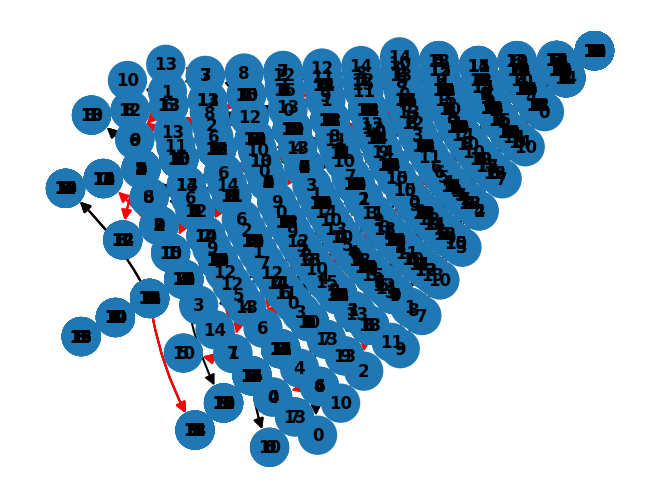

In [12]:
for g in outputs.values():
    if not g["full_path_in_subpaths"]:
        print(g["graph"])
        parse_example(g["graph"])
        print(g["reversed_subpaths"])

12>15,12>7,1>12,9>10,5>1,0>9,0>2,6>5,6>0,11>14,13>6,3>11,3>4,8>13,8>3|7:8>13>6>5>1>12>7
['6', '0', '9', '10']


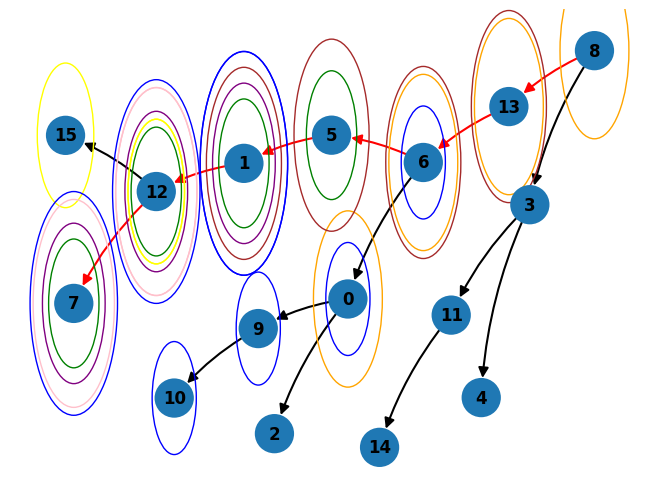

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from tree_generation.viz import hierarchy_pos

def parse_example(example_str: str, reversed_subpaths: list = []):
    # ... [existing code]

    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    node_edge_sizes = [0 for i in range(len(nodes))]
    for edge in edgelist:
        if edge in path_edges:
            color = "red"
        else:
            color = "black"
        G.add_edge(edge[0], edge[1], color=color)
    pos = hierarchy_pos(G)
    new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
    nx.draw(
        G,
        pos=new_pos,
        font_weight="bold",
        connectionstyle='arc3, rad = 0.1',
        with_labels=True,
        edgecolors="darkgoldenrod",
        linewidths=node_edge_sizes,
        arrowsize=15,
        width=1.5,
        node_size=800,
        edge_color=[G[u][v]['color'] for u, v in G.edges()]
    )

    # Now, draw the circles for reversed_subpaths
    radius_increment = 0.007  # Increment radius for each subpath
    base_radius = 0.05       # Starting radius for the circles
    colors = ['blue', 'green', 'yellow', 'purple', 'orange',"brown","pink"]  # Add more colors if needed

    for i, subpath in enumerate(reversed_subpaths):
        for node in subpath:
            node_pos = new_pos[int(node)]
            circle = plt.Circle(node_pos, base_radius + i * radius_increment, color=colors[i % len(colors)], fill=False)
            plt.gca().add_artist(circle)

    plt.show()


example =outputs[list(outputs.keys())[1]]
print(example["graph"])
print( example["reversed_subpaths"][:][0])

parse_example(example["graph"], example["reversed_subpaths"][:][:])


In [14]:
example["subpaths"]

KeyError: 'subpaths'

In [58]:
import torch
import os

def load_lenses(directory="lenses"):
    lenses = {}
    for filename in os.listdir(directory):
        if filename.endswith(".pt"):
            key = filename[:-3]  # Remove the ".pt" extension
            filepath = os.path.join(directory, filename)
            lenses[key] = torch.load(filepath)
    return lenses

lenses= load_lenses()

def logit_lens_all_probs(pred, model, dataset, position, lenses=None):
    # Get labels and cache
    labels, cache = get_example_cache(pred, model, dataset)
    current_node = int(labels[position].split(">")[-1])
    current_neighbors = [f">{i}" for i in range(dataset.n_states)]
    # Get the logit lens for each layer's resid_post
    probs = {key: [] for key in current_neighbors}
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.softmax(-1)
        for key in probs:
            key_prob = out_proj[position, dataset.tokens2idx[key]].item()
            probs[key].append(key_prob)
    # Plot data
    for key in probs:
        plt.plot(probs[key], label=key)
    plt.xlabel("Layer")
    plt.ylabel(f"Probability of Token")
    plt.title(f"Probability of Correct Token at {labels[position]}")
    plt.legend()
    plt.show()
    # Return result
    return probs

probs = logit_lens_all_probs(example["graph"], model, dataset, 48, lenses=lenses)

FileNotFoundError: [Errno 2] No such file or directory: 'lenses'

In [ ]:
logit_lens(example["graph"], model, dataset, lenses=lenses)

: 

In [ ]:
is_not_corrects = [(k, v) for k, v in outputs.items() if v["full_path_in_subpaths"] == False]
is_not_corrects

: 

In [ ]:
is_corrects = [v["is_correct"] for k, v in outputs.items()]
print(f"is_corrects: {sum(is_corrects) / len(is_corrects)}")

full_path_in_subpathss = [v["full_path_in_subpaths"] for k, v in outputs.items()]
print(f"full_path_in_subpathss: {sum(full_path_in_subpathss) / len(full_path_in_subpathss)}")

: 

### Subpath Probing

### Attention Head Visualization

In [ ]:
import re

def replace_numbers_with_characters(strings_list):
    result = []
    for string in strings_list:
        # Find all numbers in the string
        numbers = re.findall(r'\d+', string)
        if numbers:
            # Assume there is exactly one number in the string
            number = int(numbers[0])
            # Check if the number is within the range 0-25
            if 0 <= number <= 25:
                # Convert the number to the corresponding alphabet character
                char = chr(ord('A') + number)
                # Replace the number with the character
                new_string = string.replace(numbers[0], char)
                # Add a space in front of each character
                spaced_string = ' '.join(new_string)
                result.append(spaced_string)
            else:
                print(f"The number {number} in string '{string}' is out of range (0-25).")
                # Add a space in front of each character
                spaced_string = ' '.join(string)
                result.append(spaced_string)
        else:
            # Add a space in front of each character
            spaced_string = ' '.join(string)
            result.append(spaced_string)
    return result

def display_head(cache, labels, layer, head, show=False):
    average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
    last_idx = average_patterns.shape[-1] - 1
    while labels[last_idx] == ",":
        last_idx -= 1
    last_idx += 1
    path_start_pos = labels.index(":") + 1
    edge_list_end_post = labels.index("|")

    matrix = average_patterns[0, head, path_start_pos:last_idx, :edge_list_end_post].cpu()
    labels = [l.replace(">", "\u2192") for l in labels]
    labels = replace_numbers_with_characters(labels)
    
    labels_y = labels[path_start_pos:last_idx]
    labels_x = labels[:edge_list_end_post]
    fig = px.imshow(
        matrix,
        labels=dict(x="Previous Token attended to", y="Correct Next Step", color="Value"),
        color_continuous_scale="Blues",
        zmin=0,
        zmax=1,
        aspect="auto"
    )
    
    layout = dict(
        width=1200,
        height=400,
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels_x,
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels_y,
        )
    )
    fig.update_layout(layout)
    if show:
        fig.show()
    else:
        return fig
    
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache[1], cache[0], l, h, show=False)
        fig.write_image(f'./images/attn_{l}_{h}.png')

: 

In [ ]:
average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
        last_idx = average_patterns.shape[-1] - 1
        while labels[last_idx] == ",":
            last_idx -= 1
        last_idx += 1
        path_start_pos = labels.index(":") + 1
        edge_list_end_post = labels.index("|")

        matrix = average_patterns[0, head, path_start_pos:last_idx, :edge_list_end_post].cpu()
        labels = [l.replace(">", "\u2192") for l in labels]
        labels = replace_numbers_with_characters(labels)
        
        labels_y = labels[path_start_pos:last_idx]
        labels_x = labels[:edge_list_end_post]
        

: 

In [ ]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache[1], cache[0], l, h, show=True)

: 

In [ ]:
cache[1].keys()

: 

### Probing Dataset

In [ ]:
#act_names = ["ln_final.hook_normalized"]
#act_names += [f"blocks.{i}.ln2.hook_normalized" for i in range(model.cfg.n_layers)]
act_names = [f"blocks.4.ln1.hook_normalized"]
#act_names += [f"blocks.{i}.mlp.hook_post" for i in range(model.cfg.n_layers)]
import random
model.reset_hooks()

def aggregate_activations(model, dataset, activation_keys, n_samples, order, path_length=None):
    act_cache = {ak: [] for ak in activation_keys}
    graphs = []
    for _ in range(n_samples):
        example_graph = generate_example(
            n_states=dataset.n_states,
            seed=random.randint(300_000, 1_000_000_000),
            path_length=path_length,
            order=order
        )
        correct = is_model_correct(model, dataset, example_graph)
        if not correct:
            continue
        _, cache = get_example_cache(example_graph, model, dataset)
        graphs.append(example_graph)
        for key in activation_keys:
            act_cache[key].append(cache[key].cpu())
    return act_cache, graphs

activations_file = "activations_L4_ln1_normalized.pt"
if not os.path.exists(activations_file):
    print("Generating activations ...")
    
    acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=64_000,
        order="backward"
    )

    test_acts, test_graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=8_000,
        order="backward"
    )
    
    torch.save( (acts, graphs, test_acts, test_graphs) , activations_file)
else:
    print("loading activations ... ")
    acts, graphs, test_acts, test_graphs = torch.load(activations_file)


: 

In [ ]:
def extract_transposed_adj_matrix(example_str, power=1):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    for edge in edgelist:
        if edge in path_edges:
            color = "red"
        else:
            color = "black"
        G.add_edge(edge[0], edge[1], color=color)
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray().T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency

: 

In [ ]:
def extract_transposed_adj_matrix_only_path(example_str, power=1, transposed=False):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    for edge in edgelist:
        if edge in path_edges:
            G.add_edge(edge[0], edge[1])
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray()
    if transposed:
        adjacency = adjacency.T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency

: 

In [ ]:
import numpy as np
import networkx as nx

def extract_transposed_adj_matrix_only_path(example_str, N, power=1, transposed=False):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node, in_node = map(int, e.split(">"))
        edgelist.append((out_node, in_node))
        nodes.update([out_node, in_node])
    
    # Extract path
    goal = example_str.split("|")[1]
    goal_node, path_str = goal.split(":")
    goal_node = int(goal_node)
    path = list(map(int, path_str.split(">")))
    
    # Only include the last N edges from the goal in the path
    if N > 0:
        path = path[-(N+1):]
    
    path_edges = list(zip(path[:-1], path[1:]))
    
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist, f"Edge {edge} not in edgelist"
    
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for edge in edgelist:
        if edge in path_edges:
            G.add_edge(*edge)
    
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray()
    if transposed:
        adjacency = adjacency.T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency


: 

In [ ]:
acts.keys()

: 

: 

In [ ]:
def return_probing_dataset(acts, graphs):
    X = {key: [] for key in acts.keys()}
    y = []
    for gidx, graph in enumerate(graphs):
        # Get output labels
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") + 1
        # get adjacency matrix of only path
        y.append(extract_transposed_adj_matrix_only_path(graph, None).flatten())
        # Iterate over all layers residual streams
        for key in X.keys():
            # streams = acts[key][gidx][0, start_idx-1:start_idx]  # only pos 47
            streams = acts[key][gidx][0, start_idx-1:start_idx]
            X[key].append(streams)
    # Convert everything to np arrays
    for key in X.keys():
        X[key] = torch.cat(X[key], dim=0).detach().cpu().numpy()
    y = np.array(y)
    return X, y


dataX, y = return_probing_dataset(acts, graphs)
dataXTest, y_test = return_probing_dataset(test_acts, test_graphs)

: 

In [ ]:
from sklearn.model_selection import train_test_split

len(dataX["blocks.4.hook_resid_post"])
dataX, dataXTest, y, y_test = train_test_split(dataX["blocks.4.hook_resid_post"], y, test_size=0.2, random_state=42)


len(dataX)
len(dataXTest)

: 

### Nonlinear Probing

In [ ]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

import warnings
warnings.filterwarnings("ignore")


probe = probing.NonlinearMultiClsProbe(max_iter=1000, verbose=True, learning_rate_init=1e-3)
probe.fit(dataX, y.astype(np.float32))
print(probe.score(dataX, y))

answers = (probe.predict(dataXTest) > 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

: 

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

: 

In [ ]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

for label in acts.keys():
    print(label)

    X = dataX[label]
    X_test = dataXTest[label]

    probe = probing.LinearMultiClsProbe(max_iter=1000, verbose=True)
    probe.fit(X, y.astype(np.float32))
    print(probe.score(X, y))

    answers = (probe.predict(X_test) > 0.5)
    y_pred = answers.flatten()
    y_true = y_test.flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print('Accuracy: {:.2f}%'.format(accuracy*100))
    print('Precision: {:.2f}%'.format(precision*100))
    print('Recall: {:.2f}%'.format(recall*100))

: 

: 

In [ ]:
for test_example_idx in range(10):

    correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
    parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
    plt.show()

: 

### Sparse Coding + Linear Probing

In [ ]:

coder = SparseCoder(4096, max_iter=5_000, batch_size=8192, l1_coef=0.001, learning_rate_init=3e-4, verbose=True)
coder.fit(X)

: 

In [ ]:
from sparse_coding import *

d_model = dataX['blocks.4.hook_resid_post'].shape[-1]
coder = SparseCoder(num_codes=4*d_model, verbose=True)

# train
coder.fit(dataX['blocks.4.hook_resid_post'])
torch.save(coder.model.state_dict(), f'sae_resid_post_4.pt')


: 

In [ ]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

probe = probing.NonlinearMultiClsProbe(max_iter=600, verbose=True)
features = coder.featurize(X.astype(np.float32))
probe.fit(features, y.astype(np.float32))
print(probe.score(features,y.astype(np.float32)))
feats = coder.featurize(X_test)

: 

In [ ]:
linear_probe = probing.LinearMultiClsProbe(max_iter=1000, verbose=True)
features = coder.featurize(X.astype(np.float32))
linear_probe.fit(features, y.astype(np.float32))
print(linear_probe.score(features,y.astype(np.float32)))
feats = coder.featurize(X_test)

: 

In [ ]:
answers = (probe.predict(feats )> 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

: 

In [ ]:
for test_example_idx in range(10):

    correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
    parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
    plt.show()

: 